# 1. Setup Paths for Tensorflow APIs

In [1]:
import os

In [2]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [3]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [4]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 2. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [ ]:
# https://www.tensorflow.org/install/source_windows

In [ ]:
if os.name=='nt':
    !pip install wget
    import wget

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
import wget
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

# verifying whether all the dependies are installed

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

# importing all the necessary modules

In [17]:
import object_detection
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util
from pathlib import Path
import numpy as np
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import time
from scipy.spatial import distance
import time
from sklearn.naive_bayes import GaussianNB
import pandas as pd

# 3. moving model to the specific directory

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# 4. Create Label Map

In [ ]:
labels = [{'name':'Mask', 'id':1}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 5. Create TF records

In [ ]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [ ]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

# 6. Copy Model Config to Training Folder

In [ ]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

In [ ]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [ ]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)

# 7. writing values to config file

In [ ]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [ ]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)


# 8. Training model 

In [ ]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [ ]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

# Mostly run this query through cmd

In [ ]:
print(command)

In [ ]:
!{command}

# 9. loading trained model for mask detection from the checkpoints

In [7]:
labels = [{'name':'Mask', 'id':1}]
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections


# defining category index

In [8]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

# defining function to get the face from the image 

In [9]:
def get_face(image):
    img = cv2.imread(image)

    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Load the cascade
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    return img,faces

# defining this function to save the image.
# 1. First it will detect the face from the image
# 2. Then it will divide the detect face into two halfs, first half and second half
# 3. Then first it will check the complete face if no mask is there then it will store the full face image.
# 4. If mask is there in the image then it will store the upper half image of the face

In [10]:
def save_images(image):
    
    #taking image path
    img_name = image

    #calling method to get the face from the image
    img, faces = get_face(img_name)

    # Draw rectangle around the faces and crop the faces
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
        faces = img[y:y + h, x:x + w]
        #plt.imshow(faces)
        cv2.imwrite('face.jpg', faces)
    
    #detecting the height and width of the face detected in the image
    height = faces.shape[0]
    width = faces.shape[1]

    #area of the image
    area = height * width

    #Cut the image in half horizontally and dividing the detected face into two halfs upper and lower half
    width_cutoff = height // 2
    
    #upper half
    up = faces[:width_cutoff, :]
    
    #lower half
    down = faces[width_cutoff:, :]
    
    #storing those complete, upper and lower half of the face in the list
    parts = [faces,up,down]
    count = 0
    
    #It is the directory where image will get stored
    IMAGES_PATH = 'Persons_image'

    #running loop through out the list
    for part in parts:
        class_name ='no'
        
        #converting image to array
        image_np = np.array(part)
        
        #converting image array to tensor
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        
        #calling function to detect boxes, classes and scores
        detections = detect_fn(input_tensor)
        
        #number of detections
        num_detections = int(detections.pop('num_detections'))
        
        detections = {key: value[0, :num_detections].numpy()
                      for key, value in detections.items()}
        detections['num_detections'] = num_detections

        # detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        label_id_offset = 1
        image_np_with_detections = image_np.copy()
        
        #visualizing the image with following detections
        viz_utils.visualize_boxes_and_labels_on_image_array(
                    image_np_with_detections,
                    detections['detection_boxes'],
                    detections['detection_classes']+label_id_offset,
                    detections['detection_scores'],
                    category_index,
                    use_normalized_coordinates=True,
                    max_boxes_to_draw=2,
                    min_score_thresh=.8,
                    agnostic_mode=False)
        
        #plotting images
        plt.imshow(image_np_with_detections)
        plt.show()

        #Save images to the directory
        classes = set(detections['detection_classes'])
        for clas in classes:
            print(detections['detection_scores'][clas])
            if detections['detection_scores'][clas] > 0.7:
                class_name = category_index[clas+1]['name']
                count = count+1
                if class_name == 'no':
                    name = input('Enter Name: ')
                    imgname = os.path.join(IMAGES_PATH +'.'+'{}.jpg'.format(name))
                    cv2.imwrite(imgname, part)
                    print('Image Saved!')
            else:
                if class_name == 'no':
                    name = input('Enter Name: ')
                    imgname = os.path.join(IMAGES_PATH+'/'+'{}.jpg'.format(name))
                    part = cv2.cvtColor(part, cv2.COLOR_BGR2RGB)
                    cv2.imwrite(imgname, part)
                    print('Image Saved!')
                count = 0
        if count == 0:
            break

# defining function get the faces from the images and then save it

In [11]:
def save_and_get_face(image):
    
    img = cv2.imread(image)
    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Load the cascade
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
        faces = img[y:y + h, x:x + w]
        #plt.imshow(faces)
        faces = cv2.cvtColor(faces, cv2.COLOR_BGR2RGB)
        cv2.imwrite('face.jpg', faces)
    
    image_path = 'face.jpg'
    
    return image_path

# defining a class to create a model which will detect the faces and the person to whome it belongs to in the live cam, 
# First it will find the features from the images and then basis of the features person in the video will be classified using gaussian classifier.

In [12]:
class Detect_person_model:
    def __init__(self, model, featue_extractor,image_path):
        #print("Begin")
        self.image_name = ''
        self.model = model
        self.feat_extractor = featue_extractor
       # print('Model created')
        #here getting all the images from the directory where we are saving persons images
        self.IMAGES_PATH = 'Persons_image'
        self.images_path = self.IMAGES_PATH

        #this will be the extensions of our images
        self.image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
        self.max_num_images = 10000

        self.images = self.get_images()        
       # print(self.images)
       # print("keeping %d images to analyze" % len(self.images))
        
        self.features = self.get_features()
        #print('finished extracting features for %d images' % len(self.images))
        
        self.features = np.array(self.features)
        self.pca = PCA()
        self.pca.fit(self.features)
        self.pca_features = self.pca.transform(self.features)
        
        self.data = pd.DataFrame(self.pca_features)
        self.data['names'] = self.get_name(self.images)
        
        self.x_data = self.data.drop(['names'], axis =1)
        self.y_data = self.data['names']
        
        self.classifier = GaussianNB()
        self.trained_model = self.train_model(self.classifier,self.x_data,self.y_data)
        
        self.query_image1 = image_path
    
        #calling function to getting and saving the faces from the image
        #print(self.query_image1)
        self.query_image = self.save_and_get_face(self.query_image1)

        #calling function to to load the face image
        self.new_image, self.x = self.load_image(self.query_image)

        #finding the feature from the face image
        self.new_features = self.feat_extractor.predict(self.x)
        self.new_pca_features = self.pca.transform(self.new_features)[0]
        
        self.input_data = [self.new_pca_features]
        self.image_name = self.trained_model.predict(self.input_data)[0]
        

        # display the resulting images
    
    def train_model(self,model,x,y):
        model = model.fit(x,y)
        return model

    def get_name(self,image_names):
    
        i_name = []
        for name in image_names:
            Name = Path(name).stem
            i_name.append(Name)

        return i_name
    
    def save_and_get_face(self,image):
        
        img = cv2.imread(image)
        # Convert into grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Load the cascade
        face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

        # Detect faces
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)

        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            faces = img[y:y + h, x:x + w]
            #plt.imshow(faces)
            faces = cv2.cvtColor(faces, cv2.COLOR_BGR2RGB)
            cv2.imwrite('face.jpg', faces)

        image_path = 'face.jpg'

        return image_path
    
    def get_features(self):
        features = []
        tic = time.perf_counter()
        for i, image_path in enumerate(self.images):
            if i % 500 == 0:
                toc = time.perf_counter()
                elap = toc-tic;
                #print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(self.images),elap))
                tic = time.perf_counter()
            img, x = self.load_image(image_path);
            feat = self.feat_extractor.predict(x)[0]
            features.append(feat)
            
        return features
        
        
    def get_images(self):
        images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(self.images_path) for f in filenames if os.path.splitext(f)[1].lower() in self.image_extensions]
        if self.max_num_images < len(images):
            images = [images[i] for i in sorted(random.sample(xrange(len(images)), self.max_num_images))]
        return images
    
    def load_image(self,path):
        img = image.load_img(path, target_size=self.model.input_shape[1:3])
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return img, x
    
    

# defining a class to create a model which will detect the faces and the person to whome it belongs to in the live cam, 
# First it will find the features from the images and then we will find the cosine similarity between the requested and stored images features

In [13]:
class Detect_person:
    def __init__(self, model, featue_extractor,image_path):
        #print("Begin")
        
        self.model = model
        self.feat_extractor = featue_extractor
       # print('Model created')
        #here getting all the images from the directory where we are saving persons images
        self.IMAGES_PATH = 'Persons_image'
        self.images_path = self.IMAGES_PATH

        #this will be the extensions of our images
        self.image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
        self.max_num_images = 10000

        self.images = self.get_images()        
       # print(self.images)
       # print("keeping %d images to analyze" % len(self.images))
        
        self.features = self.get_features()
        #print('finished extracting features for %d images' % len(self.images))
        
        self.features = np.array(self.features)
        self.pca = PCA()
        self.pca.fit(self.features)
        self.pca_features = self.pca.transform(self.features)
        
        self.query_image1 = image_path
    
        #calling function to getting and saving the faces from the image
        #print(self.query_image1)
        self.query_image = self.save_and_get_face(self.query_image1)

        #calling function to to load the face image
        self.new_image, self.x = self.load_image(self.query_image)

        #finding the feature from the face image
        self.new_features = self.feat_extractor.predict(self.x)
        self.new_pca_features = self.pca.transform(self.new_features)[0]

        # calculate its distance to all the other images pca feature vectors
        self.distances = [ distance.cosine(self.new_pca_features, feat) for feat in self.pca_features ]

        #finding the most similar image
        self.idx_closest = sorted(range(len(self.distances)), key=lambda k: self.distances[k])[0:1]  # grab first 5
        self.results_image = self.get_concatenated_images(self.idx_closest, 200)

        # display the images
        #self.plot_image(self.new_image, "Query Image")
        
        self.name = self.get_name(self.images,self.idx_closest)
        #self.plot_image(self.results_image,self.name)

        # display the resulting images
    
    def return_name(self):
        return self.name
    
    def plot_image(self,image,name):
        plt.figure(figsize = (5,5))
        plt.imshow(image)
        plt.title(name)

    def get_name(self,image_names, index):
    
        image_path = image_names[index[0]]
        Name = Path(image_path).stem

        return Name
    
    def save_and_get_face(self,image):
        
        img = cv2.imread(image)
        # Convert into grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Load the cascade
        face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

        # Detect faces
        faces = face_cascade.detectMultiScale(gray, 1.1, 4)

        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 0, 255), 2)
            faces = img[y:y + h, x:x + w]
            #plt.imshow(faces)
            faces = cv2.cvtColor(faces, cv2.COLOR_BGR2RGB)
            cv2.imwrite('face.jpg', faces)

        image_path = 'face.jpg'

        return image_path
    
    def get_features(self):
        features = []
        tic = time.perf_counter()
        for i, image_path in enumerate(self.images):
            if i % 500 == 0:
                toc = time.perf_counter()
                elap = toc-tic;
                #print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(self.images),elap))
                tic = time.perf_counter()
            img, x = self.load_image(image_path);
            feat = self.feat_extractor.predict(x)[0]
            features.append(feat)
            
        return features
        
        
    def get_images(self):
        images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(self.images_path) for f in filenames if os.path.splitext(f)[1].lower() in self.image_extensions]
        if self.max_num_images < len(images):
            images = [images[i] for i in sorted(random.sample(xrange(len(images)), self.max_num_images))]
        return images
    
    def load_image(self,path):
        img = image.load_img(path, target_size=self.model.input_shape[1:3])
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        return img, x
    
    def get_concatenated_images(self,indexes, thumb_height):
        thumbs = []
        for idx in indexes:
            img = image.load_img(self.images[idx])
            img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
            thumbs.append(img)
        concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
        return concat_image
    

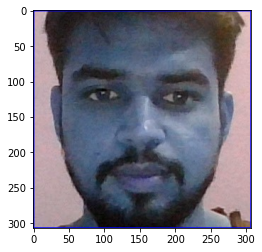

0.12669723
Enter Name: Gagan
Image Saved!


In [14]:
save_images('TEST/face.jpg')

# creating VGG16 model and feature extractor model using VGG16 model using tensorflow

In [15]:
model = tf.keras.applications.VGG16(weights='imagenet', include_top=True)
time.sleep(4)
feat_extractor = tf.keras.Model(inputs=model.input, outputs=model.get_layer("fc2").output)

# for live video cam detection

In [21]:
cap = cv2.VideoCapture(0)
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
while(True):
    ret, frame = cap.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imwrite('input_image.jpg', frame)
    
    input_image = 'input_image.jpg'
    
    faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=5,minSize=(30, 30))
    detect = Detect_person_model(model, feat_extractor,input_image)
    name = detect.image_name

    for (x, y, w, h) in faces:
        img = cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(img, name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    
    

KeyboardInterrupt: 

In [22]:
cap.release()
cv2.destroyAllWindows()